# Содержание

**Исследование тарифов оператора сотовой связи**

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Таблица users (информация о пользователях):  
**user_id** — уникальный идентификатор пользователя  
**first_name** — имя пользователя  
**last_name** — фамилия пользователя  
**age** — возраст пользователя (годы)  
**reg_date** — дата подключения тарифа (день, месяц, год)  
**churn_date** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
**city** — город проживания пользователя  
**tarif** — название тарифного плана  
Таблица calls (информация о звонках):  
**id** — уникальный номер звонка  
**call_date** — дата звонка  
**duration** — длительность звонка в минутах  
**user_id** — идентификатор пользователя, сделавшего звонок  
Таблица messages (информация о сообщениях):  
**id** — уникальный номер сообщения  
**message_date** — дата сообщения  
**user_id** — идентификатор пользователя, отправившего сообщение  
Таблица internet (информация об интернет-сессиях):  
**id** — уникальный номер сессии  
**mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах)  
**session_date** — дата интернет-сессии  
**user_id** — идентификатор пользователя  
Таблица tariffs (информация о тарифах):  
**tariff_name** — название тарифа  
**rub_monthly_fee** — ежемесячная абонентская плата в рублях  
**minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату  
**messages_included** — количество сообщений в месяц, включённых в абонентскую плату  
**mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
**rub_per_minute** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
**rub_per_message** — стоимость отправки сообщения сверх тарифного пакета  
**rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

# Изучение данных <a id="start"></a>

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

In [3]:
try:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv', index_col=0)
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
except:
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv', index_col=0) 
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
    users = pd.read_csv('users.csv')

In [4]:
calls.info()
internet.info()
messages.info()
tariffs.info()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   

In [5]:
calls.duplicated().sum()
internet.duplicated().sum()
messages.duplicated().sum()

0

## Выводы <a id="conclusion_1"></a>

Вцелом, данные впорядке, пропуски в столбце 'churn_date' означают, что тариф действующий для клиента.  
Требуется заменить некоторые типы данных: 
* привести все даты к типу DateTime;


# Предподготовка данных <a id="preprocessing"></a>

Приведем даты к типу DateTime и добавим столбец с месяцами

In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")
calls['month'] = pd.DatetimeIndex(calls['call_date']).month 
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")
messages['month'] = pd.DatetimeIndex(messages['message_date']).month 
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")
internet['month'] = pd.DatetimeIndex(internet['session_date']).month 

In [7]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


In [8]:
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [9]:
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Сгруппируем данные по пользователям и месяцам, и объеденим таблицы в один датафрейм

In [10]:
internet_grouped = internet.groupby(['month','user_id']).sum().reset_index()

In [11]:
# Так как по условию каждый звонок у нас округляется вверх до минут, то так и сделаем
calls['duration'] = calls['duration'].apply(math.ceil)

In [12]:
calls_grouped = (calls.groupby(['month','user_id'])
                 .agg({'duration':'sum', 'id':'count'})
                 .reset_index()
                 .rename(columns={'duration':'minutes_in_month', 'id':'calls_in_month'})
                )

In [13]:
messages_grouped = (messages
                    .groupby(['month','user_id'])
                    .count()
                    .reset_index()
                    .rename(columns={'message_date': 'message_in_month'})
                   )

In [14]:
data = calls_grouped.merge(messages_grouped, on=['user_id','month'], how='outer')
data = data.merge(internet_grouped, on=['user_id','month'], how='outer')
data = data.merge(users[['user_id','tariff','city']], on='user_id', how='left')
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})
data = data.merge(tariffs, on='tariff', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  3214 non-null   int64  
 1   user_id                3214 non-null   int64  
 2   minutes_in_month       3174 non-null   float64
 3   calls_in_month         3174 non-null   float64
 4   id                     2717 non-null   float64
 5   message_in_month       2717 non-null   float64
 6   mb_used                3203 non-null   float64
 7   tariff                 3214 non-null   object 
 8   city                   3214 non-null   object 
 9   messages_included      3214 non-null   int64  
 10  mb_per_month_included  3214 non-null   int64  
 11  minutes_included       3214 non-null   int64  
 12  rub_monthly_fee        3214 non-null   int64  
 13  rub_per_gb             3214 non-null   int64  
 14  rub_per_message        3214 non-null   int64  
 15  rub_

In [15]:
data['user_id'].value_counts()

1005    12
1395    12
1337    12
1340    12
1372    12
        ..
1170     1
1190     1
1192     1
1194     1
1140     1
Name: user_id, Length: 498, dtype: int64

В процессе объединения появились строчки с пропущенными значениями. Заменим их нулями, так как это означает, что пользователь не использовал эту функцию.

In [16]:
data.fillna(0, inplace = True)

In [17]:

data.isna().sum()

month                    0
user_id                  0
minutes_in_month         0
calls_in_month           0
id                       0
message_in_month         0
mb_used                  0
tariff                   0
city                     0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт.   
Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.  
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону.   
Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.
Поэтому округлим секунды до минут и приведем данные в удобный формат, так как небывает половины смс и звонка

Поэтому округлим секунды до минут и приведем данные в удобный формат, так как небывает половины смс и звонка

In [18]:
data['message_in_month'] = data['message_in_month'].astype('int')
data['calls_in_month'] = data['calls_in_month'].astype('int')

In [19]:
users[users['user_id'] == 1128] # "Эти трое не пользуются ничем
users[users['user_id'] == 1273]
users[users['user_id'] == 1371]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Удалим лишние столбцы, а то таблица и без них громоздкая

In [20]:
data.drop(['id'], axis=1, inplace=True)
data

,month,user_id,minutes_in_month,calls_in_month,message_in_month,mb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1,1005,95.0,15,7,2727.97,smart,Набережные Челны,50,15360,500,550,200,3,3
1,1,1032,380.0,61,38,24127.69,smart,Ульяновск,50,15360,500,550,200,3,3
2,1,1045,9.0,1,5,2346.71,smart,Улан-Удэ,50,15360,500,550,200,3,3
3,1,1055,551.0,64,30,17090.88,smart,Казань,50,15360,500,550,200,3,3
4,1,1071,194.0,24,16,15604.34,smart,Омск,50,15360,500,550,200,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1231,0.0,0,191,32448.00,ultra,Чебоксары,1000,30720,3000,1950,150,1,1
3210,12,1328,0.0,0,7,39419.73,ultra,Мурманск,1000,30720,3000,1950,150,1,1
3211,12,1473,0.0,0,20,18418.26,ultra,Красноярск,1000,30720,3000,1950,150,1,1
3212,12,1489,0.0,0,35,17322.51,smart,Санкт-Петербург,50,15360,500,550,200,3,3


Посчитаем и добавим в таблицу месячную выручку с каждого клиента

In [21]:
# С помощью функции высчитываем выручку с человека, после чего прибавляем абонентскую плату
def profit(row):
    sms = (row['message_in_month'] - row['messages_included']) * row['rub_per_message']
    inet = math.ceil((row['mb_used'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb']
    call = (row['minutes_in_month'] - row['minutes_included']) * row['rub_per_minute']
    total = 0
    for i in [sms,inet,call]:
        if i > 0: 
            total += i
    return total
        
data.insert(9, 'profit', data.apply(profit, axis=1))
data['profit'] += data['rub_monthly_fee']

# Исследование поведения пользователей с разними тарифами 
<a id="analisys"></a>

Для дальнейших исследований нам понадобится данные отдельно по тарифам

In [22]:
df_smart = data.query('tariff == "smart"')
df_ultra = data.query('tariff == "ultra"')


## Распределение пользователей по минутам в месяц <a id="calls"></a>

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,417.934948,190.313730,0.0,282.0,422.0,545.0,1435.0
ultra,985.0,526.623350,317.606098,0.0,284.0,518.0,752.0,1673.0


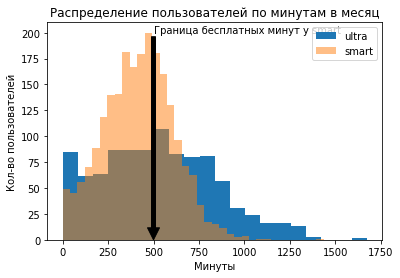

In [23]:
df_ultra['minutes_in_month'].plot(kind='hist', bins=20, label='ultra')
df_smart['minutes_in_month'].plot(kind='hist', bins=35, alpha=0.5, label='smart')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Минуты')
plt.title('Распределение пользователей по минутам в месяц')
plt.legend()
plt.annotate('Граница бесплатных минут у smart', xy=(500, 0), xytext=(500, 200),
            arrowprops=dict(facecolor='black'));
data.groupby('tariff')['minutes_in_month'].describe()

На "смарте" большиство людей не выходят за пределы бесплатных минут, а пользователи "ультра", даже близко не подходят к границе.  

## Распределение пользователей по СМС в месяц <a id="sms"></a>

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,33.384029,28.227876,0.0,10.0,28.0,51.0,143.0
ultra,985.0,49.363452,47.804457,0.0,6.0,38.0,79.0,224.0


tariff
smart     796.812958
ultra    2285.266143
Name: message_in_month, dtype: float64

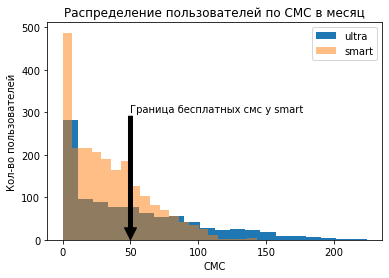

In [24]:
df_ultra['message_in_month'].plot(kind='hist', bins=20, label='ultra')
df_smart['message_in_month'].plot(kind='hist', bins=20, alpha=0.5, label='smart')
plt.ylabel('Кол-во пользователей')
plt.xlabel('СМС')
plt.title('Распределение пользователей по СМС в месяц')
plt.legend()
plt.annotate('Граница бесплатных смс у smart', xy=(50, 0), xytext=(50, 300),
            arrowprops=dict(facecolor='black'));
display(data.groupby('tariff')['message_in_month'].describe())
data.groupby('tariff')['message_in_month'].var()

Такая же ситуация и с смс: пользователи "смарт" в большинстве случаев доходят до границы бесплатных смс, в то время как у самого активного пользователя "ультра" остается еще более 750 смс.  


## Распределение пользователей по Мб в месяц <a id="inet"></a>

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,16208.386990,5870.476681,0.0,12643.01,16506.84,20042.93,38552.45
ultra,985.0,19468.805208,10087.170752,0.0,11770.26,19308.01,26837.69,49745.69


tariff
smart    3.446250e+07
ultra    1.017510e+08
Name: mb_used, dtype: float64

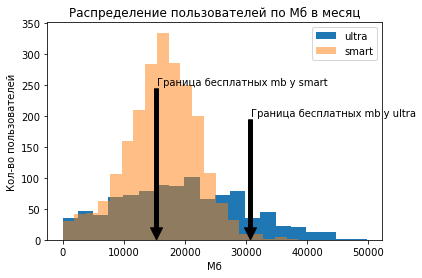

In [25]:
df_ultra['mb_used'].plot(kind='hist', bins=20, label='ultra')
df_smart['mb_used'].plot(kind='hist', bins=20, alpha=0.5, label='smart')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Мб')
plt.title('Распределение пользователей по Мб в месяц')
plt.legend()
plt.annotate('Граница бесплатных mb у smart', xy=(15360, 0), xytext=(15360, 250),
            arrowprops=dict(facecolor='black'))
plt.annotate('Граница бесплатных mb у ultra', xy=(30720, 0), xytext=(30720, 200),
            arrowprops=dict(facecolor='black'));
display(data.groupby('tariff')['mb_used'].describe())
data.groupby('tariff')['mb_used'].var()

А вот с интернет-трафиком дела обстоят иначе: людям с тарифом "ультра" в основном хватает 30Гб, и лишь немногие выходят за границы, а среди пользователей "смарт" же большая половина превышает этот предел.  

## Распределение пользователей по прибыли в месяц <a id="profit"></a>

,tariff,count,mean,std,min,25%,50%,75%,max
0,smart,2229.0,1289.973531,818.404367,550.0,550.0,1023.0,1750.0,6770.0
1,ultra,985.0,2070.152284,376.187114,1950.0,1950.0,1950.0,1950.0,4800.0


tariff
smart    669785.708006
ultra    141516.745079
Name: profit, dtype: float64

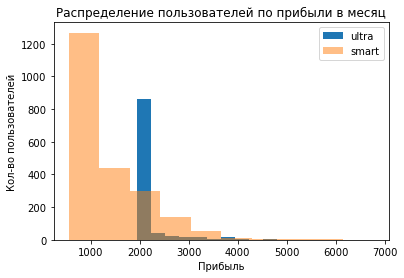

In [26]:
df_ultra['profit'].plot(kind='hist', bins=10, label='ultra')
df_smart['profit'].plot(kind='hist', bins=10, alpha=0.5, label='smart')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Прибыль')
plt.title('Распределение пользователей по прибыли в месяц')
plt.legend();
display(data.groupby('tariff')['profit'].describe().reset_index())
data.groupby('tariff')['profit'].var()

In [27]:
all_ultra_profit = int(data.groupby('tariff')['profit'].describe().reset_index().loc[1,'count'] * 
                    data.groupby('tariff')['profit'].describe().reset_index().loc[1,'mean'])
all_smart_profit = int(data.groupby('tariff')['profit'].describe().reset_index().loc[0,'count'] * 
                    data.groupby('tariff')['profit'].describe().reset_index().loc[0,'mean'])

In [28]:
print(f'''Вцелом, кажется, что прибыль с тарифа "смарт" больше, чем с "ультра", даже учитывая разницу в кол-ве пользователей каждого тарифа.
Так годовая прибыль со всех пользователей "смарт" из выборки: {all_smart_profit}р, а прибыль с "ультра": {all_ultra_profit}р, разница составляет: {abs(all_smart_profit - all_ultra_profit)}р''')

Вцелом, кажется, что прибыль с тарифа "смарт" больше, чем с "ультра", даже учитывая разницу в кол-ве пользователей каждого тарифа.
Так годовая прибыль со всех пользователей "смарт" из выборки: 2875351р, а прибыль с "ультра": 2039099р, разница составляет: 836252р


## Вывод <a id="conclusion_2"></a>

Проанализировав дынные можно сделать заключение, что около 70-75% пользователей тарифа "смарт" укладываются в лимит тарифа, однако оставшиеся приносят телекому бОльшую прибыль, в то время как пользователи ультра превышают лимит только в интернет-трафике.  
Средняя прибыль в месяц со "смарта" =  1289р, а с "ультра" = 2070р

# Исследование потребности пользователей втечение месяца <a id="month"></a>

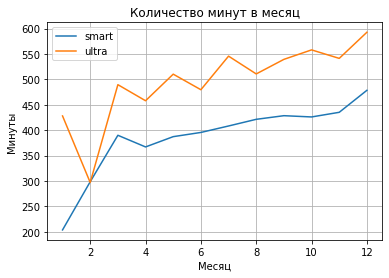

In [29]:
df_smart.groupby('month')['minutes_in_month'].mean().plot(label='smart')
df_ultra.groupby('month')['minutes_in_month'].mean().plot(grid = True, label='ultra')
plt.title('Количество минут в месяц')
plt.ylabel('Минуты')
plt.xlabel('Месяц')
plt.legend();

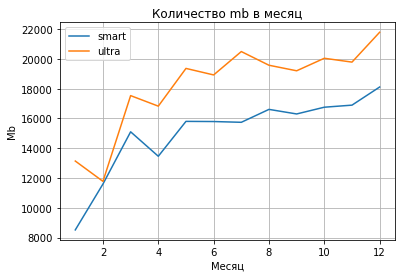

In [30]:
df_smart.groupby('month')['mb_used'].mean().plot(label='smart')
df_ultra.groupby('month')['mb_used'].mean().plot(grid = True, label='ultra')
plt.title('Количество mb в месяц')
plt.ylabel('Mb')
plt.xlabel('Месяц')
plt.legend();

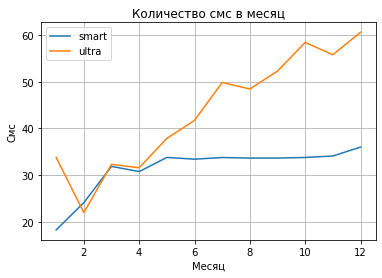

In [31]:
df_smart.groupby('month')['message_in_month'].mean().plot(label='smart')
df_ultra.groupby('month')['message_in_month'].mean().plot(grid = True, label='ultra')
plt.title('Количество смс в месяц')
plt.ylabel('Смс')
plt.xlabel('Месяц')
plt.legend();

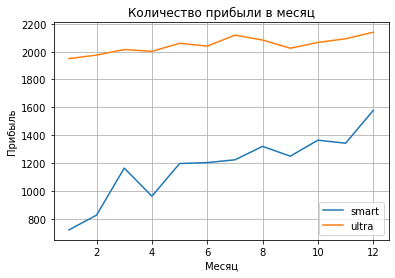

In [32]:
df_smart.groupby('month')['profit'].mean().plot(label='smart')
df_ultra.groupby('month')['profit'].mean().plot(grid = True, label='ultra')
plt.title('Количество прибыли в месяц')
plt.ylabel('Прибыль')
plt.xlabel('Месяц')
plt.legend();

## Вывод <a id="conclusion_3"></a>

Вцелом видно, что потребности пользователей обоих тарифов, как и прибыль с каждого, в течение года возрастает, достигая пика в декабре.

# Проверка гипотез <a id="hypotheses"></a>

Перед проверкой гипотез необходимо избавиться от выбросов, так как они могут повлиять на результаты

In [33]:
columns = ['message_in_month','minutes_in_month','mb_used','profit']
def boxplot_df(data, columns):
    i = 1
    for column in columns:
        plt.subplot (2, 2, i)
        data[column].plot(kind='box', figsize=(10,10), grid=True)
        plt.ylabel('Частота')
        i +=1  


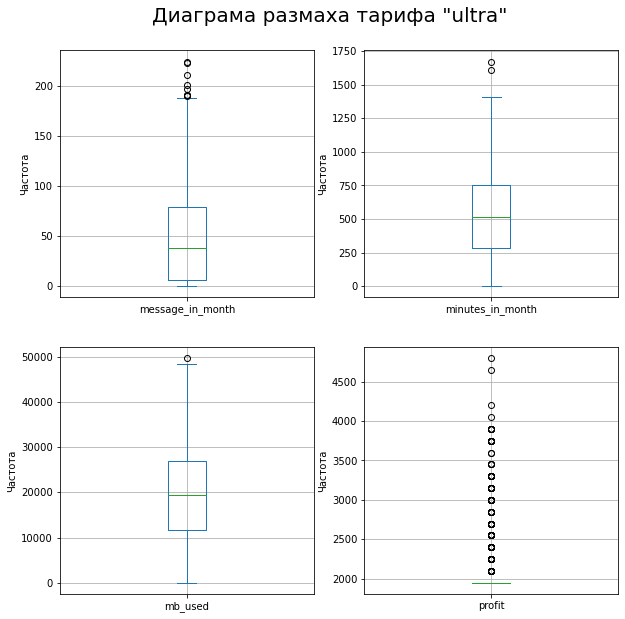

In [34]:
boxplot_df(df_ultra, columns)
plt.suptitle('Диаграма размаха тарифа "ultra"',y = 0.94, fontsize = 20);

Хотя размах прибыли "ультра" и выглядит подозрительно, но не стоит удивляться, ведь колоссальная доля клиентов не выходит за рамки абонентской платы

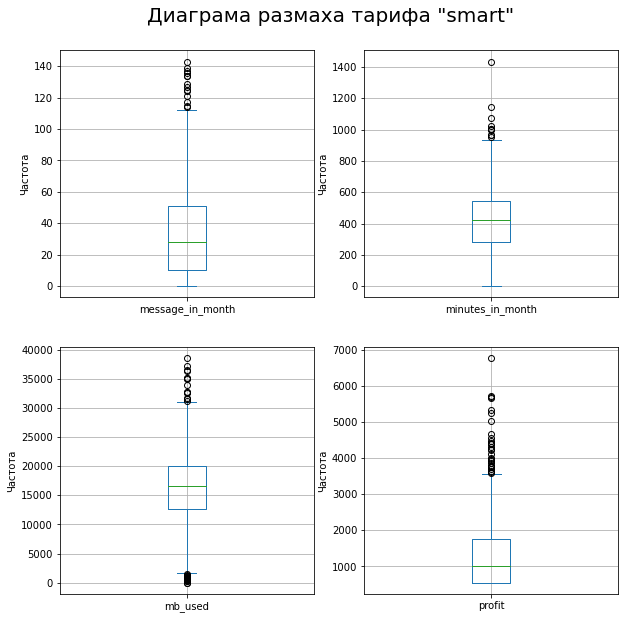

In [35]:
boxplot_df(df_smart, columns)
plt.suptitle('Диаграма размаха тарифа "smart"',y = 0.94, fontsize = 20);

Удалим выбросы!

In [36]:
# Сделал её немного более общей. М.б. пригодится в других исследованиях.
def remove_outliers(data, columns):
    for column in columns:
        q_1,q_3 = data[column].quantile([0.25,0.75])
        iqr = q_3 - q_1
        low = q_1 - (1.5 * iqr)   
        up = q_3 + (1.5 * iqr)
        data = data[(data[column] <= up) & (data[column] >= low)]
    return data

df_smart = remove_outliers(df_smart,['profit'])
df_ultra = remove_outliers(df_ultra, ['profit'])

## Гипотеза о равенстве выручек "смарт" и "ультра" <a id="hypothesis_1"></a>

Так как выборки независимы, а, благодаря ЦПТ мы знаем, что выборочные средние нормально распределены вокруг истинного среднего, применим тест Стьюдента для сравнения двух генеральных совокупностей

H0: cредняя выручка пользователей "смарт" и "ультра" одинаковы;  
H1: средняя выручка пользователей "смарт" и "ультра" различаются; 


In [37]:
alpha = 0.05
result = st.ttest_ind(df_smart['profit'], df_ultra['profit'])

print(f' p-value = {result.pvalue}')
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

 p-value = 6.199325734910117e-155
Отвергаем нулевую гипотезу


### Вывод <a id="conclusion_4"></a>

In [38]:
print(f'''Полученное значение p-value говорит о том, что вероятность получить такое различие случайно = {result.pvalue:.2%}
Опровергаем нулевую теорию. Данная разница не случайна, прибыль с тарифов отличается.''')

Полученное значение p-value говорит о том, что вероятность получить такое различие случайно = 0.00%
Опровергаем нулевую теорию. Данная разница не случайна, прибыль с тарифов отличается.


## Гипотеза о равенстве выручек пользователей из Москвы и других регионов <a id="hypothesis_2"></a>

H0: cредняя выручка пользователей из Москвы и других регионов одинаковы;  
H1: средняя выручка пользователей из Москвы и других регионов различаются; 


In [39]:
data['city'].unique() # дубликатов нет

array(['Набережные Челны', 'Ульяновск', 'Улан-Удэ', 'Казань', 'Омск',
       'Чита', 'Краснодар', 'Санкт-Петербург', 'Красноярск',
       'Архангельск', 'Ставрополь', 'Кострома', 'Волгоград', 'Тамбов',
       'Москва', 'Киров', 'Ростов-на-Дону', 'Уфа', 'Вологда', 'Пенза',
       'Магнитогорск', 'Иркутск', 'Орёл', 'Астрахань', 'Подольск',
       'Ярославль', 'Новокузнецк', 'Нижний Тагил', 'Мурманск', 'Самара',
       'Воронеж', 'Пермь', 'Саранск', 'Новосибирск', 'Владивосток',
       'Нижний Новгород', 'Новороссийск', 'Брянск', 'Челябинск',
       'Калининград', 'Барнаул', 'Якутск', 'Тольятти', 'Курган', 'Томск',
       'Балашиха', 'Саратов', 'Петрозаводск', 'Тюмень', 'Курск', 'Тула',
       'Сочи', 'Оренбург', 'Смоленск', 'Хабаровск', 'Рязань', 'Махачкала',
       'Тверь', 'Ижевск', 'Чебоксары', 'Белгород', 'Череповец',
       'Стерлитамак', 'Владимир', 'Волжский', 'Калуга', 'Екатеринбург',
       'Севастополь', 'Нижневартовск', 'Грозный', 'Владикавказ', 'Химки',
       'Сургут', 'Липе

In [40]:
data['region'] = data['city'].where(data['city'] == 'Москва', 'Другой регион')
data

,month,user_id,minutes_in_month,calls_in_month,message_in_month,mb_used,tariff,city,messages_included,profit,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,region
0,1,1005,95.0,15,7,2727.97,smart,Набережные Челны,50,550.0,15360,500,550,200,3,3,Другой регион
1,1,1032,380.0,61,38,24127.69,smart,Ульяновск,50,2350.0,15360,500,550,200,3,3,Другой регион
2,1,1045,9.0,1,5,2346.71,smart,Улан-Удэ,50,550.0,15360,500,550,200,3,3,Другой регион
3,1,1055,551.0,64,30,17090.88,smart,Казань,50,1103.0,15360,500,550,200,3,3,Другой регион
4,1,1071,194.0,24,16,15604.34,smart,Омск,50,750.0,15360,500,550,200,3,3,Другой регион
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1231,0.0,0,191,32448.00,ultra,Чебоксары,1000,2250.0,30720,3000,1950,150,1,1,Другой регион
3210,12,1328,0.0,0,7,39419.73,ultra,Мурманск,1000,3300.0,30720,3000,1950,150,1,1,Другой регион
3211,12,1473,0.0,0,20,18418.26,ultra,Красноярск,1000,1950.0,30720,3000,1950,150,1,1,Другой регион
3212,12,1489,0.0,0,35,17322.51,smart,Санкт-Петербург,50,950.0,15360,500,550,200,3,3,Другой регион


In [41]:
df_moscow = remove_outliers(data.query('region == "Москва"'), ['profit'])
df_other = remove_outliers(data.query('region == "Другой регион"'), ['profit'])

In [42]:
alpha = 0.05
result = st.ttest_ind(df_moscow['profit'], df_other['profit'])
print(f'p-value = {result.pvalue}')
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value = 0.29404256281786206
Не удалось отвергнуть нулевую гипотезу


### Вывод <a id="conclusion_5"></a>

In [43]:
print(f'''Шанс случайно получить такое различие значений выборки из генеральной совокупности = {result.pvalue:.2%}, 
что слишком велико для случайности, по-этому отвергнуть теорию о равности прибыли у клиентов из Москвы и других нерионов нельзя''')

Шанс случайно получить такое различие значений выборки из генеральной совокупности = 29.40%, 
что слишком велико для случайности, по-этому отвергнуть теорию о равности прибыли у клиентов из Москвы и других нерионов нельзя


# Выводы <a id="conclusions"></a>

Мы исследовали данные пользователей телеком компании "Мегалайн", посчитали и добивили выручку в месяц с каждого пользователя и выяснили, что около 70-75% пользователей тарифа "смарт" укладываются в лимит тарифа, однако оставшиеся приносят телекому бОльшую прибыль, в то время как пользователи ультра превышают лимит только в интернет-трафике.  
Так же мы провели статистические тесты и выяснили, что выручка с пользователей тарифов "смарт" и "ультра" различается, а вот гипотезу, что выручка с москвичей и жителей других регионов одинаковы, мы не смогли опровергнуть, так как p_value слишком высок.

Средняя прибыль в месяц с клиента "смарта" = 1289р, а с "ультра" = 2070р.
Таким образом, зная что годовая прибыль со всех пользователей "смарт" из выборки: 2875351р, а прибыль с "ультра": 2039099р и разница составляет: 836252р, делаем вывод, что тариф Смарт приносит больше прибыли компании.


In [44]:
data

,month,user_id,minutes_in_month,calls_in_month,message_in_month,mb_used,tariff,city,messages_included,profit,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,region
0,1,1005,95.0,15,7,2727.97,smart,Набережные Челны,50,550.0,15360,500,550,200,3,3,Другой регион
1,1,1032,380.0,61,38,24127.69,smart,Ульяновск,50,2350.0,15360,500,550,200,3,3,Другой регион
2,1,1045,9.0,1,5,2346.71,smart,Улан-Удэ,50,550.0,15360,500,550,200,3,3,Другой регион
3,1,1055,551.0,64,30,17090.88,smart,Казань,50,1103.0,15360,500,550,200,3,3,Другой регион
4,1,1071,194.0,24,16,15604.34,smart,Омск,50,750.0,15360,500,550,200,3,3,Другой регион
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,12,1231,0.0,0,191,32448.00,ultra,Чебоксары,1000,2250.0,30720,3000,1950,150,1,1,Другой регион
3210,12,1328,0.0,0,7,39419.73,ultra,Мурманск,1000,3300.0,30720,3000,1950,150,1,1,Другой регион
3211,12,1473,0.0,0,20,18418.26,ultra,Красноярск,1000,1950.0,30720,3000,1950,150,1,1,Другой регион
3212,12,1489,0.0,0,35,17322.51,smart,Санкт-Петербург,50,950.0,15360,500,550,200,3,3,Другой регион
